# Identifying Central Bank Research Paradigms
## Motivation
The goal of this project is to gather text-based information on central bank research. The resulting output could then be used to identify different policy 'paradigms' between central banks. To take just one example, key words in the titles or abstracts of research papers could identify central banks that tend to rely more on top-down 'macro' models to guide their policy debate versus those that tend to focus more on bottom-up 'micro' analysis. The ultimate goal would then be to examine if different policy 'paradigms' are associated with better policy outcomes (e.g. in terms of hitting inflation targets) &mdash; conditioning on other factors.

## What I do here

As a (small) first step in this direction, in this notebook:

* I scrape the research publication histories of 17 inflation-targeting central banks that have active economic research departments;
* I use a threadpool and a queue to perform the scraping, resulting in around 7,000 papers;
* for each paper, I pull a paper identifier; author/s and title; 
* output the information from a Python dictionary into a .csv file; and
* draw some wordclouds.

## In the future

I would like to:

* scrape the associated abstracts; and
* output the information into a file format the lends itself to text-based analysis.

In [93]:
from bs4 import BeautifulSoup
import requests
!pip -q install Scrapy
from bs4 import NavigableString
import queue
from concurrent.futures import ThreadPoolExecutor
import itertools
import threading
import csv
import pandas as pd 
import matplotlib.pyplot as plt
!pip -q install wordcloud
from wordcloud import WordCloud, STOPWORDS
import numpy as np

### Function (1)
**Return a dictionary with each paper's ID, title and author/s**
* NB: This is for a single page

In [94]:
def get_papers(soup):  
    
    papers = []
    for paper in soup.findAll("li",class_="list-group-item downfree"):
        info = [desc.strip() for desc in paper.descendants if type(desc) == NavigableString]
        papers.append({'ID': info[0], 'Title': info[1], 'Author': info[3]})
        
    return(papers)

### Function (2)
**Soup the necessary URL and call Function (1) to return a dictionary**

In [95]:
def parse_papers(START_URL):
    
    page = requests.get(START_URL)
    soup = BeautifulSoup(page.text, 'html.parser')
    papers = get_papers(soup)

    return papers

### Function (3)  
**Scrape all pages for a given URL, calling Function (2) for each page**

In [96]:
def parse_all_papers(START_URL):

    current_link = START_URL   # Setting up the starting link
    items_list = []            # Create empty list
    
    no_more_pages = False
    while no_more_pages == False:
        
        items_list = items_list + parse_papers(current_link)   # Add items from page to the list
        request = requests.get(current_link)                   # Accessing text content again
        parsed_request = BeautifulSoup(request.content, 'html.parser')   # Parsing it again
        link = parsed_request.find_all('li', class_= "page-item")        # Finding next link from within tree
        try:
            if not link[-1].find('a')['href'] is False:
                current_link = current_link.rsplit('/', 1)[0]+'/'+link[-1].find('a')['href']
        except:
            no_more_pages = True
    items_list.pop(0)
    return items_list

### Create a list of URLs
* Each URL contains the first page of a central bank's research publication history
* For the purpose at hand, each URL will represent a 'task' to be handled simultaneously

In [97]:
# (1) Argentina, Australia, Brazil, Canada, EU, Indonesia, Japan, Mexico, Russia, 
# South Africa, South Korea, Turkey, Bank of England, Federal Reserve, Sweden, Norway,
# (17) New Zealand, 

START_URL = "https://ideas.repec.org/s/bcr/wpaper.html \
https://ideas.repec.org/s/rba/rbardp.html \
https://ideas.repec.org/s/bcb/wpaper.html \
https://ideas.repec.org/s/bca/bocawp.html \
https://ideas.repec.org/s/ecb/ecbwps.html \
https://ideas.repec.org/s/idn/wpaper.html \
https://ideas.repec.org/s/boj/bojwps.html \
https://ideas.repec.org/s/bdm/wpaper.html \
https://ideas.repec.org/s/bkr/wpaper.html \
https://ideas.repec.org/s/rbz/wpaper.html \
https://ideas.repec.org/s/bok/wpaper.html \
https://ideas.repec.org/s/tcb/wpaper.html \
https://ideas.repec.org/s/boe/boeewp.html \
https://ideas.repec.org/s/fip/fedgfe.html \
https://ideas.repec.org/s/hhs/rbnkwp.html \
https://ideas.repec.org/s/nzb/nzbdps.html \
https://ideas.repec.org/s/bno/worpap.html".split()

### Achieving concurrency via threading!
* Give each thread a different task (URL)
* In this case, we will handle all the tasks at once
* This is great for the purpose at hand, as I have a list of pre-defined URLs to process

In [98]:
# with ThreadPoolExecutor(17) as pool:
#       papers = pool.map(parse_all_papers, START_URL)

# print(list(papers))

### Getting familiar with using a Queue

* Each worker (17 in this case) will wait until an item (URL) becomes available on the queue
* As soon as an item becomes available it is completed by the worker
* The queue does not let an item go to more than one worker

**Useful definitions**

* queue.get() &mdash; removes and returns an item from the queue (like my_list.pop(0)); will block until an item is available
* queue.put() &mdash; put an item into the queue (i.e. a URL); use this in a loop to add all the items to the queue
* queue.task_done() &mdash; tell the queue that a task has been finished
* queue.join() &mdash; block until 'task_done' is called as many times as 'put' (i.e. all the tasks are finished)

In [54]:
# (1) Argentina, Australia, Brazil, Canada, EU, Indonesia, Japan, Mexico, Russia, 
# South Africa, South Korea, Turkey, Bank of England, Federal Reserve, Sweden, Norway,
# (17) New Zealand 

START_URL = "https://ideas.repec.org/s/bcr/wpaper.html \
https://ideas.repec.org/s/rba/rbardp.html \
https://ideas.repec.org/s/bcb/wpaper.html \
https://ideas.repec.org/s/bca/bocawp.html \
https://ideas.repec.org/s/ecb/ecbwps.html \
https://ideas.repec.org/s/idn/wpaper.html \
https://ideas.repec.org/s/boj/bojwps.html \
https://ideas.repec.org/s/bdm/wpaper.html \
https://ideas.repec.org/s/bkr/wpaper.html \
https://ideas.repec.org/s/rbz/wpaper.html \
https://ideas.repec.org/s/bok/wpaper.html \
https://ideas.repec.org/s/tcb/wpaper.html \
https://ideas.repec.org/s/boe/boeewp.html \
https://ideas.repec.org/s/fip/fedgfe.html \
https://ideas.repec.org/s/hhs/rbnkwp.html \
https://ideas.repec.org/s/nzb/nzbdps.html \
https://ideas.repec.org/s/bno/worpap.html".split()
START_URL

papers = []

def worker(i):
    while True:
        item = q.get()
        if item == 'break':
            break
        results = parse_all_papers(item)
        papers.append(results)
        q.task_done()
    
q = queue.Queue()
for url in START_URL:
    q.put(url)
    
n=17
with ThreadPoolExecutor(n) as pool:
    q_papers = pool.map(worker, range(n))
    q.join()
    for i in range(n):
        q.put('break')

## Export the paper ID, title and author/s 
* Put the output into a neat .csv file: **Central_Bank_Papers.csv**

In [55]:
def main():
    '''The Main'''

    data = papers
    with open('Central_Bank_Papers.csv', 'w', newline='') as csvfile:
        fieldnames = data[0][0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for x in range(0,16):
            for row in data[x]:
                writer.writerow(row)
main()

## Create some individual files for wordcloud charting

We will analyse the following papers:

* **Fed**: 1,694 papers since 1996; 
* **ECB**: 2,199 papers since 1999; 
* **RBA**: 463 papers since 1980; 
* **UK**: 766 papers since 1992.

In [90]:
# with open('US_Federal_Reserve.csv', 'w', newline='') as csvfile:
#     fieldnames = papers[0][0].keys()
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for row in papers[16]:
#         writer.writerow(row)
# with open('ECB.csv', 'w', newline='') as csvfile:
#     fieldnames = papers[0][0].keys()
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for row in papers[14]:
#         writer.writerow(row)
# with open('RBA.csv', 'w', newline='') as csvfile:
#     fieldnames = papers[0][0].keys()
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for row in papers[11]:
#         writer.writerow(row)
# with open('UK.csv', 'w', newline='') as csvfile:
#     fieldnames = papers[0][0].keys()
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
#     for row in papers[12]:
#         writer.writerow(row)

## Create wordclouds

In [91]:
# Create wordcloud for FED 
df = pd.read_csv(r'US_Federal_Reserve.csv', encoding ="latin-1") 
comment_words = ' '
stopwords = set(STOPWORDS)
# iterate through the csv file 
for val in df.Title:
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud_fed = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# Create wordcloud for ECB
df = pd.read_csv(r'ECB.csv', encoding ="latin-1") 
comment_words = ' '
stopwords = set(STOPWORDS)
# iterate through the csv file 
for val in df.Title:
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud_ecb = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# Create wordcloud for RBA
df = pd.read_csv(r'RBA.csv', encoding ="latin-1") 
comment_words = ' '
stopwords = set(STOPWORDS)
# iterate through the csv file 
for val in df.Title:
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud_rba = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

wordcloud_rbnz = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# Create wordcloud for BoE
df = pd.read_csv(r'UK.csv', encoding ="latin-1") 
comment_words = ' '
stopwords = set(STOPWORDS)
# iterate through the csv file 
for val in df.Title:
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud_boe = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

## Plot wordclouds

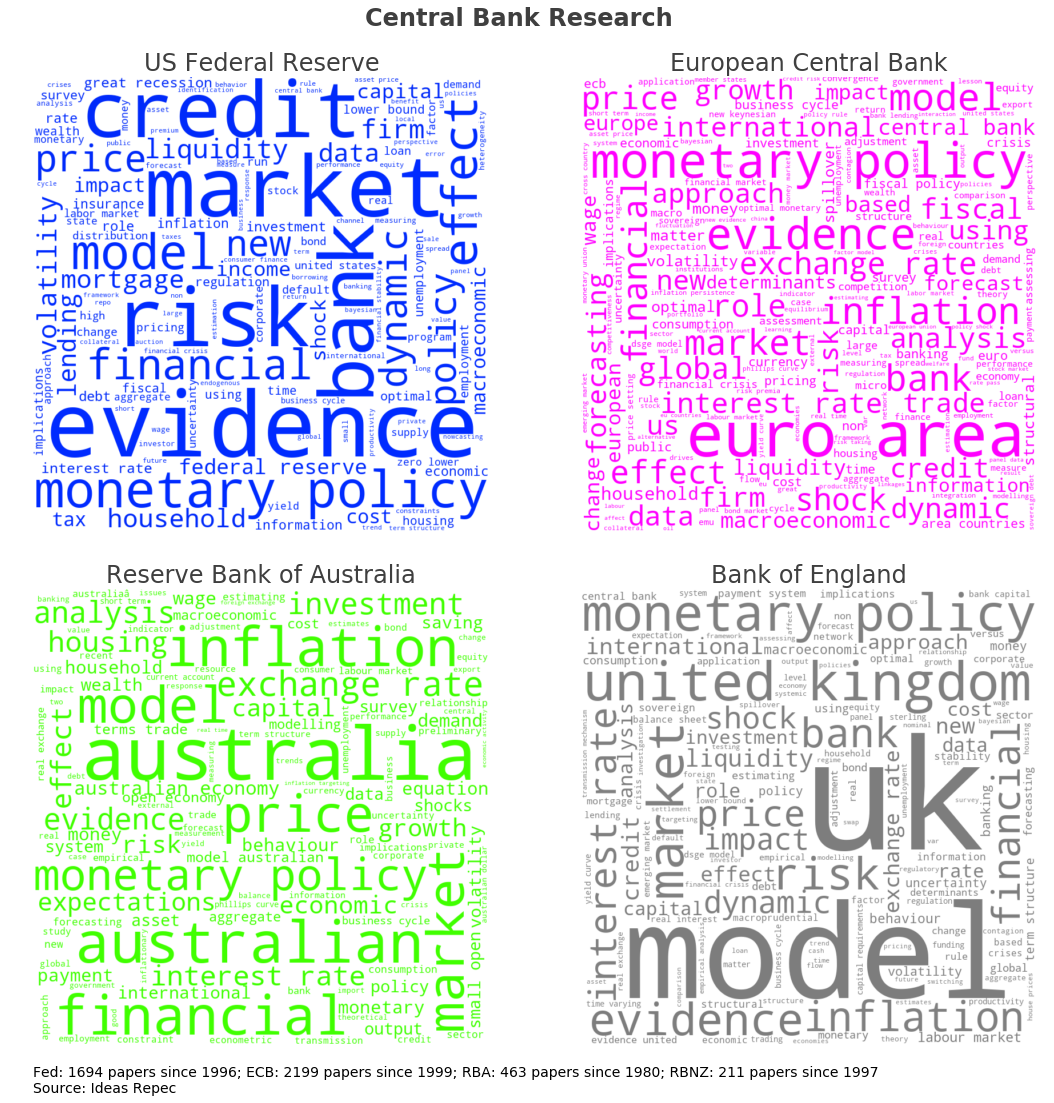

In [92]:
# Establish framework for subplots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,18))
f.suptitle('Central Bank Research', fontsize = 24, y=0.93,weight = 'bold', alpha = .75)

# Define functions for word colours
def one_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))
def two_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(300,150%%, %d%%)" % np.random.randint(49,51))
def three_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(100,150%%, %d%%)" % np.random.randint(49,51))
def four_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,0%%, %d%%)" % np.random.randint(49,51))

# Subplot 1
ax1.set_title('US Federal Reserve', fontsize = 24, y=1, alpha = .75)
ax1.imshow(wordcloud_fed.recolor(color_func=one_color_func), interpolation="bilinear")
ax1.axis("off") 

# Subplot 2
ax2.set_title('European Central Bank', fontsize = 24, y=1, alpha = .75)
ax2.imshow(wordcloud_ecb.recolor(color_func=two_color_func), interpolation="bilinear")
ax2.axis("off") 

# Subplot 3
ax3.set_title('Reserve Bank of Australia', fontsize = 24, y=1, alpha = .75)
ax3.imshow(wordcloud_rba.recolor(color_func=three_color_func), interpolation="bilinear")
ax3.axis("off") 
ax3.annotate('Fed: 1694 papers since 1996; ECB: 2199 papers since 1999; RBA: 463 papers since 1980; RBNZ: 211 papers since 1997\nSource: Ideas Repec', (0,0), (0, -20), fontsize = 14,xycoords='axes fraction', textcoords='offset points', va='top')

# Subplot 4
ax4.set_title('Bank of England', fontsize = 24, y=1, alpha = .75)
ax4.imshow(wordcloud_boe.recolor(color_func=four_color_func), interpolation="bilinear")
ax4.axis("off") 

# Make subplots close to each other
f.subplots_adjust(hspace=0.1)
plt.show()